<a href="https://colab.research.google.com/github/olufunmiruth/g05-used-cars/blob/master/preprocessing_used_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install kaggle

In [17]:
import os
os.environ['KAGGLE_USERNAME'] = "countessolufunmi" 
os.environ['KAGGLE_KEY'] = "da7d7c0b6f0bc05afa5cf56aa66fcb26" 
!kaggle datasets download -d austinreese/craigslist-carstrucks-data 

craigslist-carstrucks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!unzip /content/craigslist-carstrucks-data.zip

Archive:  /content/craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vehicles.csv            


In [19]:
!pip install catboost

In [20]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [21]:
# Loading necessary libraries
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
import datetime

In [22]:
# load dataset
df = pd.read_csv('/content/vehicles.csv')
df.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


In [23]:
df.shape

(458213, 26)

In [24]:
#drop irrelevant columns
df = df.drop(['Unnamed: 0','id','url','region_url','VIN','image_url','description'],axis = 1)

In [25]:
#check the shape after dropping columns
df.shape

(458213, 19)

In [26]:
# free up memory space
import gc
gc.collect()

0

In [27]:
# add new column 'car_age'
current_time = datetime.datetime.now()
df['car_age'] = current_time.year - df['year']

In [28]:

# Change the datatype of the year
df['year'] = df['year'].astype('str')

In [29]:
# Split the dataset based on data type for easier preprocessing
num = df.select_dtypes(include=['int64', 'float64'])
cat = df.select_dtypes(include=['object'])
cat.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,posting_date
0,auburn,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,rwd,NaN,other,NaN,al,2020-12-02T08:11:30-0600
1,auburn,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,fwd,NaN,sedan,NaN,al,2020-12-02T02:11:50-0600


In [30]:
# categorical features info
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        458213 non-null  object
 1   year          458213 non-null  object
 2   manufacturer  439993 non-null  object
 3   model         453367 non-null  object
 4   condition     265273 non-null  object
 5   cylinders     287073 non-null  object
 6   fuel          454976 non-null  object
 7   title_status  455636 non-null  object
 8   transmission  455771 non-null  object
 9   drive         324025 non-null  object
 10  size          136865 non-null  object
 11  type          345475 non-null  object
 12  paint_color   317370 non-null  object
 13  state         458213 non-null  object
 14  posting_date  458185 non-null  object
dtypes: object(15)
memory usage: 52.4+ MB


In [31]:
# Check for missing values in the categorical features
cat.isnull().sum()

region               0
year                 0
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
title_status      2577
transmission      2442
drive           134188
size            321348
type            112738
paint_color     140843
state                0
posting_date        28
dtype: int64

In [32]:
# Check for missing values within the numerical features
num.isnull().sum()

price           0
odometer    55303
lat          7448
long         7448
car_age      1050
dtype: int64

In [33]:
# Fill missing values for longitude and latitude with zero

num['lat'] = num['lat'].fillna(0)

num['long'] = num['long'].fillna(0)

In [34]:
# Import and instantiate the KNNImputer
from sklearn.impute import KNNImputer

num_imp = KNNImputer()

In [35]:
#check head
num.head(2)

,price,odometer,lat,long,car_age
0,35990,32742.0,32.5900,-85.4800,10.0
1,7500,93600.0,32.5475,-85.4682,6.0


In [36]:
# Impute missing values for the odometer feature
num['odometer_trans'] = num_imp.fit_transform(num[['odometer']])

In [37]:
# Impute missing values for the car_age feature
num['car_age_trans'] = num_imp.fit_transform(num[['car_age']])

In [38]:
# Create 3 dimensional coordinates from latitude and longitude features

num['point_x'] = np.cos(num['lat']) * np.cos(num['long'])
num['point_y'] =np.cos(num['lat']) * np.sin(num['long'])
num['point_z'] = np.sin(num['lat'])

In [39]:
#check top 2 rows
num.head(2)

,price,odometer,lat,long,car_age,odometer_trans,car_age_trans,point_x,point_y,point_z
0,35990,32742.0,32.5900,-85.4800,10.0,32742.0,10.0,-0.305961,0.235990,0.922332
1,7500,93600.0,32.5475,-85.4682,6.0,93600.0,6.0,-0.339755,0.255719,0.905082


In [40]:
# Create a list of the original numerical features
num_col = ['odometer', 'lat', 'long']

In [41]:
# create a function to impute the missing values for categorical features

def impute_nan_add_vairable(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that variable (.mode())
    
    Mode_Category = DataFrame[ColName].mode()[0]
    
    # 2.1 Replace NAN values with most occured category in actual vairable
    
    DataFrame[ColName].fillna(Mode_Category,inplace=True)


In [42]:
#check columns
cat.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state', 'posting_date'],
      dtype='object')

In [43]:
(cat['size'].isnull().sum()/cat.shape[0]) * 100

70.13070340649435

In [44]:
#check for missing values in the region column
cat.region.isnull().sum()

0

In [45]:
# Drop size column because of the volume of missing values
#Drop posting_date column due to irrelevance

cat = cat.drop(['size', 'posting_date'], axis=1)

In [46]:
# Call function to impute NAN values and add new importance feature
colls = ['year', 'manufacturer', 'model', 'condition', 'cylinders','fuel',
         'title_status', 'transmission', 'drive', 'type', 'paint_color']

for Columns in colls:
    impute_nan_add_vairable(cat,Columns)

In [47]:
gc.collect()

316

In [48]:
cat.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,year_Imputed,manufacturer_Imputed,model_Imputed,condition_Imputed,cylinders_Imputed,fuel_Imputed,title_status_Imputed,transmission_Imputed,drive_Imputed,type_Imputed,paint_color_Imputed
0,auburn,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,rwd,other,white,al,0,0,0,0,0,0,0,0,0,0,1
1,auburn,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,fwd,sedan,white,al,0,0,0,0,0,0,0,0,0,0,1


In [49]:
# Drop the original numerical features
num_main = num.drop(num_col, axis=1)

In [50]:
num_main.head(2)

,price,car_age,odometer_trans,car_age_trans,point_x,point_y,point_z
0,35990,10.0,32742.0,10.0,-0.305961,0.235990,0.922332
1,7500,6.0,93600.0,6.0,-0.339755,0.255719,0.905082


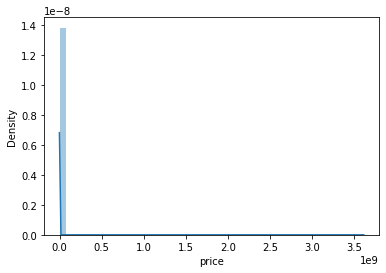

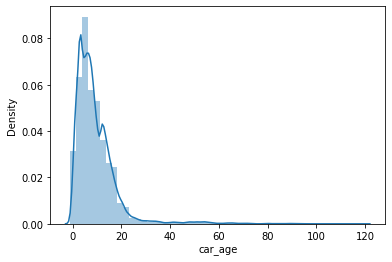

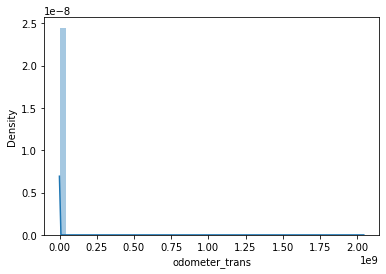

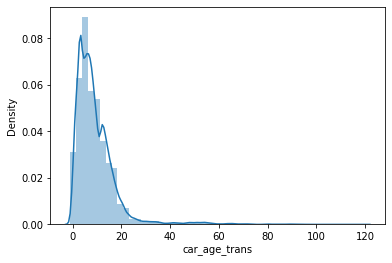

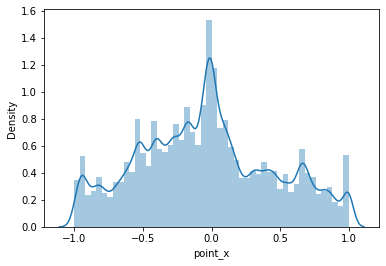

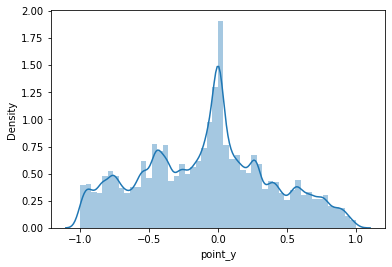

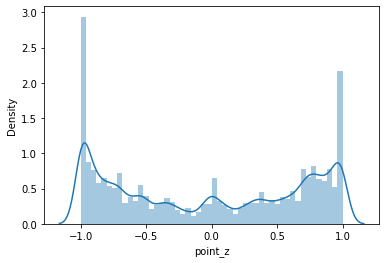

In [51]:
#create visualisation
for i in num_main.columns:
    sns.distplot(num_main[i])
    plt.show()

In [52]:
# Drop the original numerical feature-car_age
num_main = num_main.drop(['car_age'], axis=1)

In [53]:
num_main.columns

Index(['price', 'odometer_trans', 'car_age_trans', 'point_x', 'point_y',
       'point_z'],
      dtype='object')

In [54]:
gc.collect()

40874

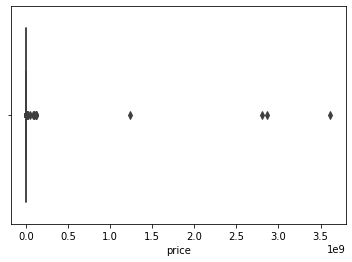

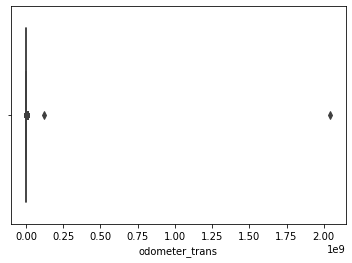

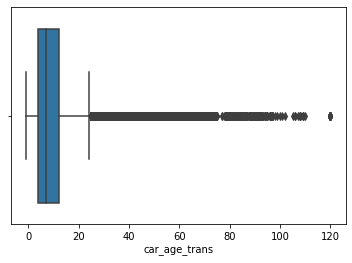

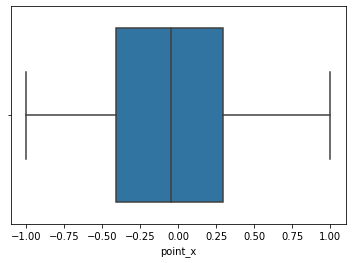

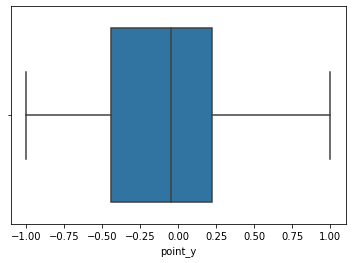

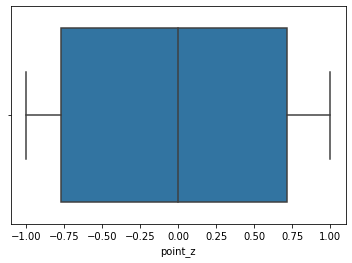

In [55]:
# create visualsations
for v in num_main.columns:
    sns.boxplot(num_main[v])
    plt.show()

In [56]:
# Import robust scaler from sklearn to scale numerical features
from sklearn.preprocessing import RobustScaler

In [57]:
#robust scaling was performed  on the selected numerical features

sc_col = ['car_age_trans', 'odometer_trans']

rs = RobustScaler()

for named in sc_col:
    num_main[named] = rs.fit_transform(num_main[[named]])

In [58]:
num_main.head(2)

,price,odometer_trans,car_age_trans,point_x,point_y,point_z
0,35990,-0.828596,0.375,-0.305961,0.235990,0.922332
1,7500,-0.069958,-0.125,-0.339755,0.255719,0.905082


In [59]:
gc.collect()

15650

In [60]:
num_main = num_main.drop(['price'], axis=1)

In [61]:
# Joining the numerical dataframe and the categorical dataframe together
Full_df = pd.concat([num_main, cat], axis=1)
Full_df.shape

(458213, 29)

In [62]:
# Saving dataframe as csv

Full_df.to_csv('clean_df.csv', index=False)

 # Baseline Model

In [53]:
# load dataset
df = pd.read_csv('/content/vehicles.csv')
df.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


In [54]:
#drop irrelevant columns
df = df.drop(['Unnamed: 0','id','url','region_url','VIN','image_url','description'],axis = 1)

In [55]:
#check the shape and information of main used_cars dataframe without irrelevant columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        458213 non-null  object 
 1   price         458213 non-null  int64  
 2   year          457163 non-null  float64
 3   manufacturer  439993 non-null  object 
 4   model         453367 non-null  object 
 5   condition     265273 non-null  object 
 6   cylinders     287073 non-null  object 
 7   fuel          454976 non-null  object 
 8   odometer      402910 non-null  float64
 9   title_status  455636 non-null  object 
 10  transmission  455771 non-null  object 
 11  drive         324025 non-null  object 
 12  size          136865 non-null  object 
 13  type          345475 non-null  object 
 14  paint_color   317370 non-null  object 
 15  state         458213 non-null  object 
 16  lat           450765 non-null  float64
 17  long          450765 non-null  float64
 18  post

In [56]:
df.shape

(458213, 19)

In [57]:
#numpy log on price
df['year'] = df['year'].astype('str')
df['price'] = np.log((df['price'] + 1))

In [58]:
#drop posting date column
df = df.drop(['posting_date'], axis=1)

In [59]:
#drop all null values
df_drop = df.dropna()

In [60]:
df_drop.shape

(86851, 18)

In [61]:
#split data into train and test sets
from sklearn.model_selection import train_test_split
train_drop, test_drop = train_test_split(df_drop, test_size=0.3, shuffle=True, random_state=2020)

In [62]:
X_train_drop = train_drop.drop(['price'], axis=1)
y_train_drop = train_drop['price']

X_test_drop = test_drop.drop(['price'], axis=1)
y_test_drop = test_drop['price']

print(X_train_drop.shape)
print(y_train_drop.shape)
print(X_test_drop.shape)
print(y_test_drop.shape)

(60795, 17)
(60795,)
(26056, 17)
(26056,)


In [63]:
X_train_drop.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
75133,high rockies,2006.0,audi,a4 2.0t quattro,good,4 cylinders,gas,204600.0,clean,manual,4wd,compact,sedan,red,co,39.628036,-106.068835
276319,hudson valley,2007.0,dodge,gr caravan w/ stow n go,like new,6 cylinders,gas,163002.0,clean,automatic,fwd,full-size,mini-van,white,ny,41.605600,-73.988000


In [64]:
X_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60795 entries, 75133 to 220706
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        60795 non-null  object 
 1   year          60795 non-null  object 
 2   manufacturer  60795 non-null  object 
 3   model         60795 non-null  object 
 4   condition     60795 non-null  object 
 5   cylinders     60795 non-null  object 
 6   fuel          60795 non-null  object 
 7   odometer      60795 non-null  float64
 8   title_status  60795 non-null  object 
 9   transmission  60795 non-null  object 
 10  drive         60795 non-null  object 
 11  size          60795 non-null  object 
 12  type          60795 non-null  object 
 13  paint_color   60795 non-null  object 
 14  state         60795 non-null  object 
 15  lat           60795 non-null  float64
 16  long          60795 non-null  float64
dtypes: float64(3), object(14)
memory usage: 8.3+ MB


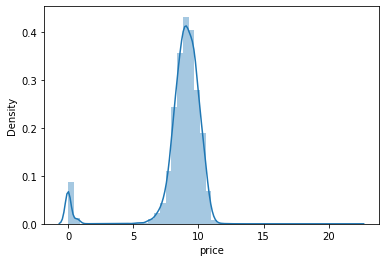

In [65]:
sns.distplot(y_train_drop)

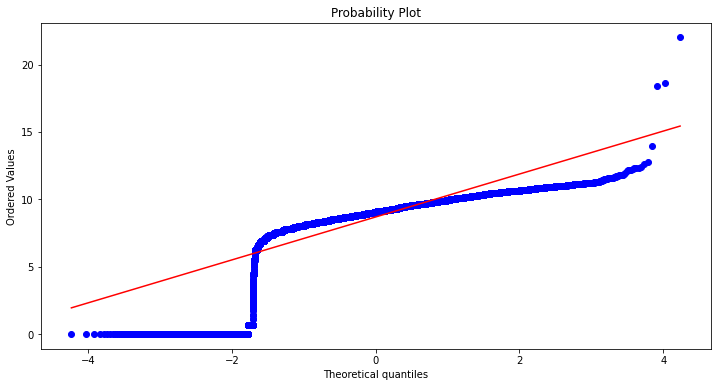

In [66]:
import pylab
from scipy import stats
plt.figure(figsize=(12, 6))
stats.probplot(y_train_drop, plot=pylab)
pylab.show()

#Catboost

In [67]:
#select acategorical features
cat_indices = np.where(X_train_drop.dtypes != np.float)[0]
cat_indices

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14])

In [68]:
from sklearn.model_selection import KFold
from math import sqrt


# Function for training the model and calculating the root mean squared error
def Training_Validation_Error_Catboost(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels ,cat_features=cat_indices)
    
    predicted = model.predict(test_data)
    
    rmse = sqrt(mean_squared_error(test_labels,predicted))
    
    print ('rmse = '+str(rmse))
           
    return(rmse)

In [69]:
gc.collect()

2531

In [70]:
kf = KFold(n_splits=10)  # Split the training data into 10 folds

from catboost import CatBoostRegressor
#KFOLD CROSSVAL FOR CATBOOST ALGORITHM

model=CatBoostRegressor(iterations=1500, depth=4, learning_rate=0.03,l2_leaf_reg=10,
                        loss_function='RMSE', random_state=350, verbose=0)
rmse_list=[]

for train_index, val_index in kf.split(X_train_drop):
    X = X_train_drop
    Y = y_train_drop
    X_train,X_val=X.iloc[train_index], X.iloc[val_index]
    Y_train,Y_val=Y.iloc[train_index], Y.iloc[val_index]
    
    rmse=Training_Validation_Error_Catboost(model,train_data = X_train,train_labels = Y_train,test_data = X_val,test_labels = Y_val)
    rmse_list.append(rmse)
    
print("mean rmse is :",np.mean(rmse_list))
print("range is :", max(rmse_list) - min(rmse_list))

rmse = 1.405142643877543
rmse = 1.4503994787541767
rmse = 1.3562156937910668
rmse = 1.346401716215981
rmse = 1.3935061468883745
rmse = 1.3053788676129117
rmse = 1.4193885117962637
rmse = 1.3285524067212566
rmse = 1.3662368811567074
rmse = 1.453252223762026
mean rmse is : 1.3824474570576308
range is : 0.14787335614911434


In [72]:
import gc
gc.collect()

0

In [73]:
#prediction
pred = model.predict(X_test_drop)

In [74]:
from sklearn.metrics import r2_score
print("R2 training", model.score(X_train_drop, y_train_drop))
print("R2 test", model.score(X_test_drop, y_test_drop))
print("R2 prediction", r2_score(y_test_drop, pred))

R2 training 0.5930598714882377
R2 test 0.5136107675820805
R2 prediction 0.5136107675820805


# Main Model


In [75]:
#Load the preprocessed data
Full_df.head()

,odometer_trans,car_age_trans,point_x,point_y,point_z,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,year_Imputed,manufacturer_Imputed,model_Imputed,condition_Imputed,cylinders_Imputed,fuel_Imputed,title_status_Imputed,transmission_Imputed,drive_Imputed,type_Imputed,paint_color_Imputed
0,-0.828596,0.375,-0.305961,0.235990,0.922332,auburn,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,rwd,other,white,al,0,0,0,0,0,0,0,0,0,0,1
1,-0.069958,-0.125,-0.339755,0.255719,0.905082,auburn,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,fwd,sedan,white,al,0,0,0,0,0,0,0,0,0,0,1
2,-0.151658,0.875,-0.289739,0.216241,0.932358,auburn,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,clean,automatic,4wd,SUV,blue,al,0,0,0,0,0,0,0,0,1,0,0
3,1.131738,4.875,-0.115278,0.047804,0.992182,auburn,1974.0,chevrolet,c-10,good,4 cylinders,gas,clean,automatic,rwd,pickup,blue,al,0,0,0,0,0,0,0,0,0,0,0
4,0.209274,1.000,-0.339755,0.255719,0.905082,auburn,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,lien,automatic,4wd,pickup,blue,al,0,0,0,0,0,0,0,0,0,0,0


In [76]:
#check shape
Full_df.shape

(458213, 29)

#check different features


In [78]:
#check different features
Full_df['year_Imputed'].value_counts()

0    458213
Name: year_Imputed, dtype: int64

In [79]:
#preprocessed data does not contain target variable, load main dataframe to retrieve target
df.price.tail()

458208     9.615539
458209     9.792333
458210     9.792612
458211     7.170888
458212    10.038936
Name: price, dtype: float64

In [80]:
target = df[['price']]

In [81]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,auburn,10.491024,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al,32.590000,-85.480000
1,auburn,8.922792,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al,32.547500,-85.468200
2,auburn,8.497195,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al,32.616807,-85.464149
3,auburn,7.601402,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al,32.861600,-85.216100
4,auburn,9.878221,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.468200


In [82]:
# Perform a log transform on the target variable
target = np.log((target + 1))

In [84]:
# Combine features and target into one dataset
dataset = pd.concat([Full_df, target], axis=1)

In [ ]:
dataset.head(2)

In [87]:
# Split the data into train and test set
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=2020)

In [88]:
X_train_ = train.drop(['price'], axis=1)
y_train_ = train['price']

X_test_ = test.drop(['price'], axis=1)
y_test_ = test['price']


print(X_train_.shape)
print(y_train_.shape)
print(X_test_.shape)
print(y_test_.shape)

(366570, 29)
(366570,)
(91643, 29)
(91643,)


In [89]:
# Check for missing value
X_train_.isnull().sum()

odometer_trans          0
car_age_trans           0
point_x                 0
point_y                 0
point_z                 0
region                  0
year                    0
manufacturer            0
model                   0
condition               0
cylinders               0
fuel                    0
title_status            0
transmission            0
drive                   0
type                    0
paint_color             0
state                   0
year_Imputed            0
manufacturer_Imputed    0
model_Imputed           0
condition_Imputed       0
cylinders_Imputed       0
fuel_Imputed            0
title_status_Imputed    0
transmission_Imputed    0
drive_Imputed           0
type_Imputed            0
paint_color_Imputed     0
dtype: int64

In [90]:
# import library for cross validation 
from sklearn.model_selection import KFold

In [91]:
# select categorical features
cat_indices = np.where(X_train_.dtypes != np.float)[0]
cat_indices

In [92]:
from math import sqrt

# Function for training the model and calculating the root mean squared error
def Training_Validation_Error_Catboost(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels ,cat_features=cat_indices)
    
    predicted = model.predict(test_data)
    
    rmse = sqrt(mean_squared_error(test_labels,predicted))
    
    print ('rmse = '+str(rmse))
           
    return(rmse)

In [ ]:
gc.collect()

In [ ]:
kf = KFold(n_splits=10)  # Split the training data into 10 folds

from catboost import CatBoostRegressor
#KFOLD CROSSVAL FOR CATBOOST ALGORITHM

model=CatBoostRegressor(iterations=1500, depth=4, learning_rate=0.03,l2_leaf_reg=10,
                        loss_function='RMSE', random_state=350, verbose=0, early_stopping_rounds=300)
rmse_list=[]

for train_index, val_index in kf.split(X_train_):
    X = X_train_
    Y = y_train_
    X_train,X_val=X.iloc[train_index], X.iloc[val_index]
    Y_train,Y_val=Y.iloc[train_index], Y.iloc[val_index]
    
    # Training the model
    rmse=Training_Validation_Error_Catboost(model,train_data = X_train,train_labels = Y_train,test_data = X_val,test_labels = Y_val)
    rmse_list.append(rmse)
    

print("mean rmse is :",np.mean(rmse_list))
print("range is :", max(rmse_list) - min(rmse_list))

rmse = 0.46510833996586526


In [15]:
gc.collect()

13

In [93]:
# Prediction on  test data
pred = model.predict(X_test_)

print("R2 training", model.score(X_train_, y_train_))
print("R2 test", model.score(X_test_, y_test_))
print("R2 prediction", r2_score(y_test_, pred))

CatBoostError: ignored

In [ ]:
#view columns 
X_train_.columns

In [ ]:
# categorical features with few groups
col = ['condition', 'cylinders','fuel', 'title_status', 'transmission', 'drive']

# Creating dummy variables for the features in the list 'col'
X = pd.get_dummies(X_train_, columns=col, prefix=col, prefix_sep=':', drop_first=True)

X_test = pd.get_dummies(X_test_, columns=col, prefix=col, prefix_sep=':', drop_first=True)

In [ ]:
# features with high dimensionality
feature_list = ['region', 'year', 'manufacturer', 'model', 'type', 'paint_color', 'state']

target_ = y_train_

# Perform encoding on the high dimensionality features
CBE_encoder = CatBoostEncoder()

train_cbe = CBE_encoder.fit_transform(X_train_[feature_list], target_)
print(train_cbe.shape)
test_cbe = CBE_encoder.transform(X_test_[feature_list])
print(test_cbe.shape)

In [ ]:
# Drop the original features
X_d = X.drop(feature_list, axis=1) 
X_te = X_test.drop(feature_list, axis=1)

In [ ]:
# Concatenate the different dataframes
X_T = pd.concat([X_d, train_cbe], axis=1)
X_Test = pd.concat([X_te, test_cbe], axis=1)
X_T.head(2)

In [ ]:
# Function for training the model and calculating the root mean squared error
def Training_Validation_Error(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels)
    
    predicted = model.predict(test_data)
    
    rmse = sqrt(mean_squared_error(test_labels,predicted))
    
    print ('rmse = '+str(rmse))
           
    return(rmse)

In [ ]:
kf = KFold(n_splits=10)

# XGBoost model
model_x = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.03,
                 max_depth=10,
                 min_child_weight=1.5,
                 n_estimators=1500,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42, early_stopping_rounds=300)
#KFOLD CROSSVAL FOR XGBOOST ALGORITHM


rmse_list=[]

for train_index, test_index in kf.split(X_T):
    X = X_T
    Y = y_train_
    X_train,X_val=X.iloc[train_index], X.iloc[test_index]
    Y_train,Y_val=Y.iloc[train_index], Y.iloc[test_index]   
    rmse=Training_Validation_Error(model_x,train_data = X_train,train_labels = Y_train,test_data = X_val,test_labels = Y_val)
    rmse_list.append(rmse)
    
print("mean rmse is :",np.mean(rmse_list))
print("range is :", max(rmse_list) - min(rmse_list))

In [ ]:
# Predicting on the test dataset
predi = model_x.predict(X_Test)

print("R2 training", model_x.score(X_T, y_train_))

print("R2 test", model_x.score(X_Test, y_test_))

print("R2 prediction", r2_score(y_test_, predi))

# Random Forest

In [ ]:
X_T.head(2)

In [ ]:
X_T.isnull().sum()

In [ ]:
# Creating a duplicate of the training dataframe
X_ = X_T.copy()

In [ ]:
# fill missing values in year with mode 
X_['year'] = X_T['year'].fillna(X_T['year'].mode()[0])

In [ ]:
# Confirming there are no more missing values
X_.isnull().sum()

In [ ]:
kf = KFold(n_splits=10)

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
#KFOLD CROSSVAL FOR XGBOOST ALGORITHM


rmse_list=[]

for train_index, test_index in kf.split(X_):
    X = X_
    Y = y_train_
    X_train,X_val=X.iloc[train_index], X.iloc[test_index]
    Y_train,Y_val=Y.iloc[train_index], Y.iloc[test_index]   
    rmse=Training_Validation_Error(model_rf,train_data = X_train,train_labels = Y_train,test_data = X_val,test_labels = Y_val)
    rmse_list.append(rmse)
    
print("mean rmse is :",np.mean(rmse_list))
print("range is :", max(rmse_list) - min(rmse_list))

In [ ]:
# Filling missing values for year in the test data
X_Test['year'] = X_Test['year'].fillna(X_Test['year'].mode()[0])

In [ ]:
# Predicting on the test dataset
predic = model_rf.predict(X_Test)

print("R2 training", model_rf.score(X_, y_train_))

print("R2 test", model_rf.score(X_Test, y_test_))

print("R2 prediction", r2_score(y_test_, predic))

In [ ]:
# Overall RMSE on test data for the different models
print("Catboost RMSE test_data :", sqrt(mean_squared_error(y_test_, pred)))
print("XGboost RMSE test_data :", sqrt(mean_squared_error(y_test_, predi)))
print("Random Forest RMSE test_data :", sqrt(mean_squared_error(y_test_, predic)))

In [ ]:
# Transforming the predictions made by each model
catboost_predictions = np.expm1(pred)
xgboost_predictions = np.expm1(predi)
random_forest_predictions = np.expm1(predic)

In [ ]:
pd.set_option('max_rows', None)

In [ ]:
# converting prediction arrays to lists
catb = list(catboost_predictions)
xgbb = list(xgboost_predictions)
rf_m = list(random_forest_predictions)

In [ ]:
model_dictionary = {'Catboost': catb, 'XGBoost':xgbb, 'Random_forest':rf_m}

In [ ]:
# Creating a dataframe of the predictions made by each model
df = pd.DataFrame(model_dictionary)

In [ ]:
df.head()